In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import cv2
from random import randint
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np


img_w, img_h = 224, 224    
hist_w, hist_h = 192, 192  
BATCH_SIZE = 32
learning_rate = 0.001
n_epochs = 10
print_every = 5
train_dir = '/home/elham/Desktop/gemstone/data/train/'
test_dir = '/home/elham/Desktop/gemstone/data/test/'
device = torch.device("cuda")
net = models.wide_resnet50_2(pretrained=True) 
net = net.to(device)

def read_imgs_lbls(_dir):
    Images, Labels, Hists, Masks, Results = [], [], [], [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)         
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)
                
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                original = image.copy()
                hsv_lower = np.array([0,0,20])
                hsv_upper = np.array([255,255,255])
                mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
                result = cv2.bitwise_and(original, original, mask=mask)
                
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB);
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                image_rgb[:,:,0] = cv2.equalizeHist(image_rgb[:,:,0])
                image_output = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

                Images.append(image)
                Hists.append(image_output)
                Masks.append(mask)
                Results.append(result)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    Hists = np.array(Hists)
    Masks = np.array(Masks)
    Results = np.array(Results)
    return (Images, Labels, Hists, Masks, Results,dirs)


def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels


Train_Imgs, labels, Train_Hists, Train_Masks, Train_Results,dirs = read_imgs_lbls(train_dir)
CLASSES= list(set(labels))
Train_Lbls = get_class_index(labels)
Test_Imgs, test_labels, Test_Hists, Test_Masks, Test_Results,dirs = read_imgs_lbls(test_dir)
test_CLASSES= list(set(test_labels))
Test_Lbls = get_class_index(test_labels)
print("Dataset is loaded")
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of test images: {}'.format(Test_Imgs.shape))
print('-----------------------------------------------------')


high_thresh, low_thresh = 60, 40
def edge_and_cut(img):
    try:
        img = cv2.GaussianBlur(img, (7, 7), 0)
        edges = cv2.Canny(img, high_thresh, low_thresh)
        #img = remove_shadows(img)
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img


def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

NUM_CLASSES = 87
Train_Imgs = torch.tensor(Train_Imgs).permute(0,3,1,2)
Test_Imgs = torch.tensor(Test_Imgs).permute(0,3,1,2)

train_set = torch.tensor(Train_Imgs)
test_set = torch.tensor(Test_Imgs)
train_label = torch.tensor(Train_Lbls)
test_label = torch.tensor(Test_Lbls)




#make a data loader
train_input = torch.utils.data.TensorDataset(train_set, train_label)
test_input = torch.utils.data.TensorDataset(test_set, test_label)

train_loader = torch.utils.data.DataLoader(train_input, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_input, batch_size=BATCH_SIZE, shuffle=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

net.fc = nn.Linear(2048, NUM_CLASSES, bias=True)
net.fc = net.fc.to(device) if device else net.fc


valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total= 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        outputs = net(data.float())
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (n_epochs) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t.float())
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'test loss: {np.mean(val_loss):.4f}, test acc: {(100 * correct_t/total_t):.4f}\n')

    net.train()

Shape of train images: (2856, 336, 336, 3)
Shape of train histograms: (2856, 336, 336, 3)
Shape of train labels: (2856,)
Shape of train images: (363, 336, 336, 3)
Shape of train histograms: (363, 336, 336, 3)
Shape of train labels: (363,)
-----------------------------------------------------
Epoch 1



<ipython-input-1-aa51fad4ab7e>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set = torch.tensor(Train_Imgs)
<ipython-input-1-aa51fad4ab7e>:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_set = torch.tensor(Test_Imgs)



train-loss: 4.3767, train-acc: 4.9020
test loss: 4.1481, test acc: 14.0496

Epoch 2


train-loss: 4.1277, train-acc: 25.2451
test loss: 3.8200, test acc: 33.3333

Epoch 3


train-loss: 3.8353, train-acc: 41.9468
test loss: 3.5122, test acc: 41.5978

Epoch 4


train-loss: 3.5553, train-acc: 48.8445
test loss: 3.2259, test acc: 49.8623

Epoch 5


train-loss: 3.2967, train-acc: 57.6331
test loss: 2.9778, test acc: 61.1570

Epoch 6


train-loss: 3.0673, train-acc: 65.6162
test loss: 2.7601, test acc: 66.6667

Epoch 7


train-loss: 2.8627, train-acc: 71.3936
test loss: 2.5682, test acc: 70.5234

Epoch 8


train-loss: 2.6815, train-acc: 75.7703
test loss: 2.3964, test acc: 73.8292

Epoch 9


train-loss: 2.5167, train-acc: 80.8824
test loss: 2.2522, test acc: 77.1350

Epoch 10


train-loss: 2.3670, train-acc: 83.6835
test loss: 2.1261, test acc: 76.0331



<function matplotlib.pyplot.show(*args, **kw)>

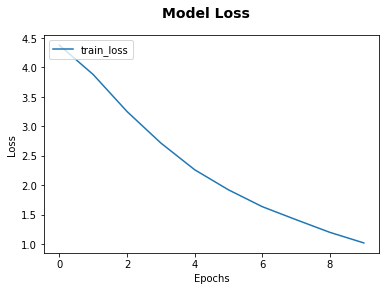

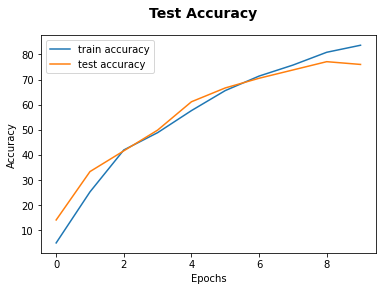

In [5]:
#plot loss 
fig = plt.figure()
fig.suptitle('Model Loss', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.plot(train_loss, label="train_loss")
plt.legend(loc="upper left")
plt.show


#plot acc 
fig = plt.figure()
fig.suptitle('Test Accuracy', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

ax.plot(train_acc, label="train accuracy")
ax.plot(val_acc, label="test accuracy")
plt.legend(loc="upper left")
plt.show

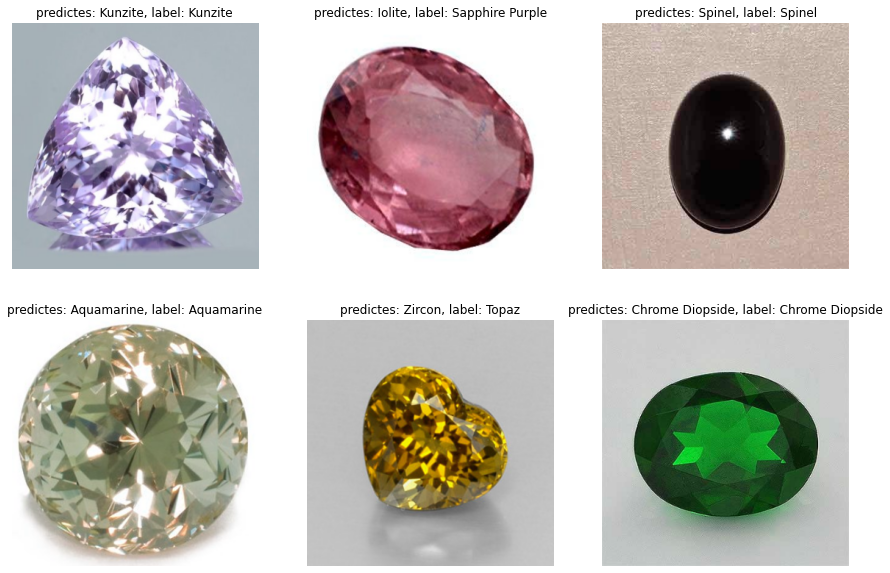

In [6]:
def visualize_model(net, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_loader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs.float())
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            #cl = Train_Lbls[preds[j]]
            predictes = CLASSES[preds[j]]
            
            #cl = Train_Lbls[labels[j]]
            annotation = CLASSES[labels[j]]
            
            #ax.set_title('predictes: {}, label: {}'.format(preds[j], labels[j]))
            ax.set_title('predictes: {}, label: {}'.format(predictes, annotation))
            
            img = inputs[j].permute(1,2,0).cpu().numpy().astype(np.uint8)
            im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imshow(im_rgb)
            if images_so_far == num_images:
                return 

from pylab import *
plt.ion()
visualize_model(net)
plt.ioff()